In [1]:
import fastf1
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np
import sympy
from shapely.affinity import translate  
import math


In [110]:
#This is the API data that we pull
#session = fastf1.get_session(2023, 'Zanvoort', 'R')
session = fastf1.get_session(2023, 'Spielberg', 'R')

session.load(telemetry=True, laps=True, weather=False)
laps = session.laps
lap_55_1 = laps.pick_driver('1').pick_lap(10).get_telemetry()
f1_api_coords = list(zip(lap_55_1["Y"],lap_55_1["X"]))

core           INFO 	Loading data for Italian Grand Prix - Race [v3.3.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed

In [111]:
def get_corners(session):
    circuit_info = session.get_circuit_info()
    corners_df = circuit_info.corners
    return corners_df

In [112]:
def coordinate_shift(original_centroid, f1_api_coords):
    """This translates the original relative coordinates into longitude and latitude
    original_centroid is the centroid computed from the downloaded track data
    """
    centroid_lon, centroid_lat = (original_centroid.x, original_centroid.y)  
      
    # conversion factors - these are approximations, adjust as necessary  
    # 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
    km_per_degree_lat = 1 / 111  
    km_per_degree_lon = 1 / (111 * math.cos(math.radians(centroid_lat)))  
    
    # your array of tuples  
    xy_coordinates = f1_api_coords
    
    # convert each tuple in the array  
    lonlat_coordinates = []  
    for y,x in xy_coordinates:  
        lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
        lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
        lonlat_coordinates.append((lon,lat))  
    return lonlat_coordinates

In [113]:
lap_55_1.head(1)

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2023-09-03 13:36:20.737,0 days 01:35:19.692000,,46.36,0 days,11033,310,8,100,False,8,interpolation,0.158361,0.000027,OnTrack,-1380.42287,-759.758846,1871.240404


In [114]:
df = lap_55_1.drop(['Date', 'DriverAhead', 'DistanceToDriverAhead', 'Time',"Source","RelativeDistance"], axis=1)  


In [115]:
print(df.head(1).to_latex())

\begin{tabular}{llrrrrrrrlrrr}
\toprule
 & SessionTime & RPM & Speed & nGear & Throttle & Brake & DRS & Distance & Status & X & Y & Z \\
\midrule
2 & 0 days 01:35:19.692000 & 11033 & 310 & 8 & 100 & False & 8 & 0.158361 & OnTrack & -1380.422870 & -759.758846 & 1871.240404 \\
\bottomrule
\end{tabular}



In [116]:
print(lap_55_1.head(1).to_latex())

\begin{tabular}{llllrlrrrrrrlrrlrrr}
\toprule
 & Date & SessionTime & DriverAhead & DistanceToDriverAhead & Time & RPM & Speed & nGear & Throttle & Brake & DRS & Source & Distance & RelativeDistance & Status & X & Y & Z \\
\midrule
2 & 2023-09-03 13:36:20.737000 & 0 days 01:35:19.692000 &  & 46.360000 & 0 days 00:00:00 & 11033 & 310 & 8 & 100 & False & 8 & interpolation & 0.158361 & 0.000027 & OnTrack & -1380.422870 & -759.758846 & 1871.240404 \\
\bottomrule
\end{tabular}



In [117]:
#This plots the 

In [ ]:
def track_buffered(track_geojson):
    # Load the GeoDataFrame
    monza_track = gpd.read_file(track_geojson) #This is monza
    #monza_track = gpd.read_file("bacinger f1-circuits master circuits/nl-1948.geojson")

    monza_track_projected = monza_track.to_crs(epsg=32632)

    # Process the geometry to add width by buffering (buffer distance in meters)
    width_in_meters = 5  # Specify the width of the track. Adjust according to needs.
    monza_track_buffered = monza_track_projected.copy(deep = True)
    monza_track_buffered['geometry'] = monza_track_buffered.geometry.buffer(width_in_meters)
    return monza_track_buffered


In [118]:
import geopandas as gpd
import folium




# Load the GeoDataFrame
monza_track = gpd.read_file("bacinger f1-circuits master circuits/it-1922.geojson") #This is monza
#monza_track = gpd.read_file("bacinger f1-circuits master circuits/nl-1948.geojson")

centroid = monza_track.geometry.centroid.iloc[0]

# Ensure the GeoDataFrame is in WGS84 (lat/lon)
#monza_track = monza_track.to_crs(epsg=4326)

# Convert to a projected CRS suitable for buffering (e.g., UTM)
# Note: Choose the correct UTM zone for your specific data. Here, we assume zone 32N.
# This is something we add manually 
monza_track_projected = monza_track.to_crs(epsg=32632)

# Process the geometry to add width by buffering (buffer distance in meters)
width_in_meters = 5  # Specify the width of the track. Adjust according to needs.
monza_track_buffered = monza_track_projected.copy(deep = True)
monza_track_buffered['geometry'] = monza_track_buffered.geometry.buffer(width_in_meters)

/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_16945/687770593.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = monza_track.geometry.centroid.iloc[0]


In [119]:
# Create a folium map centered at the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Add the GeoDataFrame to the map
folium.GeoJson(monza_track_buffered).add_to(m)

# Display the map
#m.save("monza_track_map.html")
m  # This line is optional and just to display the map inline, if your

In [120]:
def shift_centroid(point,original_centroid):
    """This shift the centroid computed"""
    # Calculate the distance to translate in each direction  

    #print(dx, dy)
    dx = -0.004080352801855369
    dy = -0.0063870841787121435
    # Shift the LineString  
    shifted_line = translate(point, xoff=dx, yoff=dy)  
    return shifted_line

def coordinate_shift(original_centroid, f1_api_coords):
    """This translates the original relative coordinates into longitude and latitude
    original_centroid is the centroid computed from the downloaded track data
    """
    centroid_lon, centroid_lat = (original_centroid.x, original_centroid.y)  
      
    # conversion factors - these are approximations, adjust as necessary  
    # 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
    km_per_degree_lat = 1 / 111  
    km_per_degree_lon = 1 / (111 * math.cos(math.radians(centroid_lat)))  
    
    # your array of tuples  
    xy_coordinates = f1_api_coords
    
    # convert each tuple in the array  
    lonlat_coordinates = []  
    for y,x in xy_coordinates:  
        lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
        lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
        lonlat_coordinates.append((lon,lat))  
    
    relative_line = LineString(lonlat_coordinates)
    return relative_line

def get_corners_transformed(session,centroid):
    data = get_corners(session)
    coords = [(row['Y'],row['X']) for index,row in data.iterrows()]

    scaled_down = coordinate_shift(centroid, coords)
    shifted_line = shift_centroid(scaled_down,centroid)


    data['shifted_x'] = [x for x, y in shifted_line.coords]
    data['shifted_y'] = [y for x, y in shifted_line.coords]
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['shifted_x'], data['shifted_y']), crs="EPSG:4326").reset_index(drop=True)
    return gdf.geometry

all_centroids = get_corners_transformed(session,centroid)

In [ ]:
def folium_with_corners2():

    
    all_centroids = get_corners_transformed(session,centroid)
    # Create a folium map centered at the centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

    # Add the GeoDataFrame to the map
    folium.GeoJson(monza_track_buffered).add_to(m)



    def add_marker(map,color, centroid, track_name, index):
        # Add a red marker with a click event to redirect to dashboard1
        red_marker = folium.CircleMarker(
            location=(centroid.y, centroid.x),
            radius=7,
            color=color,
            fill=True,
            fill_color='red'
        )
        red_marker.add_child(folium.Popup(f'<a href="/dashboard_{track_name}_{index}" target="_blank">Go to corner {index}</a>'))
        red_marker.add_to(map) 
    list_of_colors = ["green","red","blue","yellow","black"]

    for  counter, (point, color) in enumerate(zip(all_centroids,list_of_colors)):
        add_marker(m,color,point, "monza", counter)


    m
    

In [131]:
# Create a folium map centered at the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Add the GeoDataFrame to the map
folium.GeoJson(monza_track_buffered).add_to(m)



def add_marker(map,color, centroid, track_name, index):
    # Add a red marker with a click event to redirect to dashboard1
    red_marker = folium.CircleMarker(
        location=(centroid.y, centroid.x),
        radius=7,
        color=color,
        fill=True,
        fill_color='red'
    )
    red_marker.add_child(folium.Popup(f'<a href="/dashboard_{track_name}_{index}" target="_blank">Go to corner {index}</a>'))
    red_marker.add_to(map) 
list_of_colors = ["green","red","blue","yellow","black"]

for  counter, (point, color) in enumerate(zip(all_centroids,list_of_colors)):
    add_marker(m,color,point, "monza", counter)


m

In [128]:
m

0     POINT (9.28269 45.62459)
1     POINT (9.28369 45.62418)
2     POINT (9.28510 45.62435)
3     POINT (9.29228 45.62320)
4     POINT (9.29013 45.62146)
5     POINT (9.28931 45.62088)
6     POINT (9.28814 45.62083)
7     POINT (9.28584 45.61930)
8     POINT (9.28613 45.62244)
9     POINT (9.28534 45.62304)
10    POINT (9.28537 45.61649)
11    POINT (9.28905 45.61853)
12    POINT (9.29122 45.61749)
13    POINT (9.28245 45.61396)
14    POINT (9.28192 45.61456)
Name: geometry, dtype: geometry

In [62]:
m

In [10]:
m._repr_html_()

'<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe srcdoc="&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&gt;\n    \n    &lt;meta http-equiv=&quot;content-type&quot; content=&quot;text/html; charset=UTF-8&quot; /&gt;\n    \n        &lt;script&gt;\n            L_NO_TOUCH = false;\n            L_DISABLE_3D = false;\n        &lt;/script&gt;\n    \n    &lt;style&gt;html, body {width: 100%;height: 100%;margin: 0;padding: 0;}&lt;/style&gt;\n    &lt;style&gt;#map {position:absolute;top:0;bottom:0;right:0;left:0;}&lt;/style&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://code.jquery.com/jquery-3.7.1.min.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js&quot;&gt;&lt;/sc

In [14]:
centroid_lon, centroid_lat = (centroid.x, centroid.y)  

    
# conversion factors - these are approximations, adjust as necessary  
# 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
km_per_degree_lat = 1 / 110.574  
km_per_degree_lon = 1 / (111.320 * math.cos(math.radians(centroid_lat)))  



# your array of tuples  
yx_coordinates = f1_api_coords

# convert each tuple in the array  
lonlat_coordinates = []  
for y,x in yx_coordinates:  
    #Since each unit (x,y ) is in decimeters, we divide by 10000 since we are scaling pr kilomiters
    lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
    lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
    lonlat_coordinates.append((lon,lat)) 

In [15]:
relative_line = LineString(lonlat_coordinates)


In [16]:
# Your code  
gdf = gpd.GeoDataFrame(geometry=[relative_line], crs="EPSG:4326")    
new_projected = gdf.to_crs(epsg=32632)    
kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")    

# Add GeoJson with red color  
folium.GeoJson(  
    new_projected,  
    style_function=lambda feature: {  
        'color': 'blue'  
    }  
).add_to(kat)  

In [17]:
kat

In [18]:
def coordinate_shift(original_centroid, f1_api_coords):
    """This translates the original relative coordinates into longitude and latitude
    original_centroid is the centroid computed from the downloaded track data
    """
    centroid_lon, centroid_lat = (original_centroid.x, original_centroid.y)  


    

      
    # conversion factors - these are approximations, adjust as necessary  
    # 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
    km_per_degree_lat = 1 / 111  
    km_per_degree_lon = 1 / (111 * math.cos(math.radians(centroid_lat)))  
    
    # your array of tuples  
    xy_coordinates = f1_api_coords
    
    # convert each tuple in the array  
    lonlat_coordinates = []  
    for y,x in xy_coordinates:  
        lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
        lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
        lonlat_coordinates.append((lon,lat))  
    
    relative_line = LineString(lonlat_coordinates)
    return relative_line



def shift_centroid(relative_line,original_centroid):
    """This shift the centroid computed"""
    # Calculate the distance to translate in each direction  
    dx = original_centroid.x - relative_line.centroid.x  
    dy = original_centroid.y - relative_line.centroid.y  
    #print(dx, dy)
    #dx = -0.004080352801855369
    #dy = -0.0063870841787121435
    # Shift the LineString  
    shifted_line = translate(relative_line, xoff=dx, yoff=dy)  
    return shifted_line

In [19]:
def mapping_dict(track: str):
    d = {
        "monza": "bacinger f1-circuits master circuits/it-1922.geojson"
    }
    return d[track]

def show_api_data(year: int, track: str, event_type: str):

    file = mapping_dict(track) 

    track_coordinates = gpd.read_file(file) #This is monza
    #monza_track = gpd.read_file("bacinger f1-circuits master circuits/nl-1948.geojson")

    centroid = track_coordinates.geometry.centroid.iloc[0]

    session = pull_data(year, track, event_type)

    laps = session.laps
    lap_55_1 = laps.pick_driver('1').pick_lap(10).get_telemetry()
    f1_api_coords = list(zip(lap_55_1["Y"],lap_55_1["X"]))
    
    scaled_down = coordinate_shift(centroid, f1_api_coords)
    shifted_line = shift_centroid(scaled_down,centroid)


    # Update your GeoDataFrame  
    gdf = gpd.GeoDataFrame(geometry=[shifted_line], crs="EPSG:4326")    
    new_projected = gdf.to_crs(epsg=32632)  
    

    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")  
    folium.GeoJson(new_projected).add_to(kat)  
    m.save(f"html/{track}.html")

    

In [20]:
scaled_down = coordinate_shift(centroid, f1_api_coords)
shifted_line = shift_centroid(scaled_down,centroid)

In [21]:
# Your code  
gdf = gpd.GeoDataFrame(geometry=[scaled_down], crs="EPSG:4326")    
new_projected = gdf.to_crs(epsg=32632)    
kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")    
  
# Add GeoJson with red color  
folium.GeoJson(  
    monza_track_buffered,  
    style_function=lambda feature: {  
        'color': 'red'  
    }  
).add_to(kat)  

# Add GeoJson with red color  
folium.GeoJson(  
    new_projected,  
    style_function=lambda feature: {  
        'color': 'blue'  
    }  
).add_to(kat)  

folium.GeoJson(new_projected).add_to(kat)  
  
# Add a red marker  
folium.CircleMarker(  
    location=(centroid.y,centroid.x), # replace with the coordinates of the point  
    radius=5,  
    color='red',  
    fill=True,  
    fill_color='red'  
).add_to(kat)  

# Add a red marker  
folium.CircleMarker(  
    location=(scaled_down.centroid.y,scaled_down.centroid.x), # replace with the coordinates of the point  
    radius=5,  
    color='blue',  
    fill=True,  
    fill_color='blue'  
).add_to(kat)  
kat


In [24]:
import geopandas as gpd
import folium

# Your existing code to create the GeoDataFrame and project it
gdf = gpd.GeoDataFrame(geometry=[scaled_down], crs="EPSG:4326")
new_projected = gdf.to_crs(epsg=32632)

# Create the Folium map
kat = folium.Map(
    location=[centroid.y, centroid.x],
    zoom_start=14,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr="Esri"
)

# Add GeoJson with red color
folium.GeoJson(
    monza_track_buffered,
    style_function=lambda feature: {
        'color': 'red'
    }
).add_to(kat)

# Add GeoJson with blue color
folium.GeoJson(
    new_projected,
    style_function=lambda feature: {
        'color': 'blue'
    }
).add_to(kat)

# Add a red marker with a popup
folium.CircleMarker(
    location=(centroid.y, centroid.x),  # replace with the coordinates of the point
    radius=5,
    color='red',
    fill=True,
    fill_color='red',
    popup=folium.Popup("This is the red centroid marker", parse_html=True)
).add_to(kat)

# Add a blue marker with a popup
folium.CircleMarker(
    location=(scaled_down.centroid.y, scaled_down.centroid.x),  # replace with the coordinates of the point
    radius=5,
    color='blue',
    fill=True,
    fill_color='blue',
    popup=folium.Popup("This is the blue centroid marker", parse_html=True)
).add_to(kat)

# Save the map as an HTML file
#kat.save('map_with_popups.html')

# Display the map (if running in a Jupyter notebook)
kat


In [ ]:

def folium_map_with_corners(centroid, f1_api_coords):
    scaled_down = coordinate_shift(centroid, f1_api_coords)
    shifted_line = shift_centroid(scaled_down,centroid)
    # Your existing code to create the GeoDataFrame and project it
    gdf = gpd.GeoDataFrame(geometry=[scaled_down], crs="EPSG:4326")
    new_projected = gdf.to_crs(epsg=32632)

    # Create the Folium map
    kat = folium.Map(
        location=[centroid.y, centroid.x],
        zoom_start=14,
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr="Esri"
    )

    # Add GeoJson with red color
    folium.GeoJson(
        monza_track_buffered,
        style_function=lambda feature: {
            'color': 'red'
        }
    ).add_to(kat)

    # Add GeoJson with blue color
    folium.GeoJson(
        new_projected,
        style_function=lambda feature: {
            'color': 'blue'
        }
    ).add_to(kat)

    # Add a red marker with a click event to redirect to dashboard1
    red_marker = folium.CircleMarker(
        location=(centroid.y, centroid.x),
        radius=5,
        color='red',
        fill=True,
        fill_color='red'
    )
    red_marker.add_child(folium.Popup('<a href="/dashboard1" target="_blank">Go to Dashboard 1</a>'))
    red_marker.add_to(kat)

    # Add a blue marker with a click event to redirect to dashboard2
    blue_marker = folium.CircleMarker(
        location=(scaled_down.centroid.y, scaled_down.centroid.x),
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue'
    )
    blue_marker.add_child(folium.Popup('<a href="/dashboard2" target="_blank">Go to Dashboard 2</a>'))
    blue_marker.add_to(kat)

    # Save the map to an HTML string
    map_html = kat._repr_html_()
        
    #return render_template('index.html', map_html=map_html)



In [80]:
# Update your GeoDataFrame  
gdf = gpd.GeoDataFrame(geometry=[shifted_line], crs="EPSG:4326")    
new_projected = gdf.to_crs(epsg=32632)  
  

kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")  
folium.GeoJson(new_projected).add_to(kat)  
kat

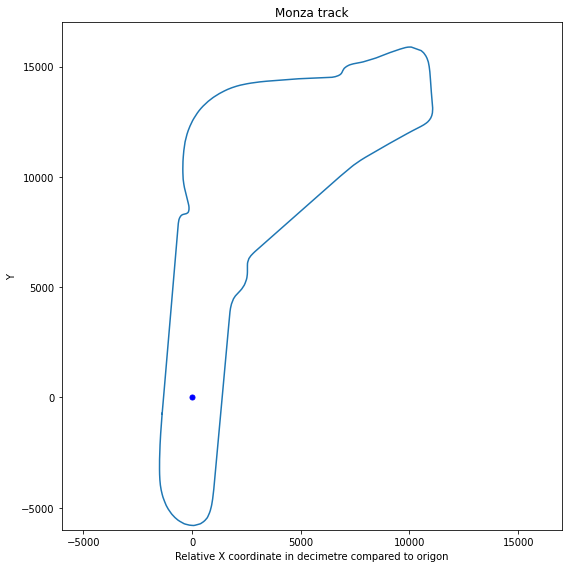

In [81]:
plt.figure(figsize=(8,8))  
  
# Get the current axes, creating one if necessary.  
ax = plt.gca()  
  
# Set the facecolor of the axes:  
ax.set_facecolor('white')  

plt.plot(lap_55_1['X'], lap_55_1['Y'], label='Driver 1')  
#plt.plot(lap_55_2['X'], lap_55_2['Y'], label='Driver 55')  
  
plt.plot(0, 0, marker='o', markersize=5, label='Point (0,0)', color='blue') # Add a blue dot at (0,0)  
  
plt.xlabel('Relative X coordinate in decimetre compared to origon')  
plt.ylabel('Y')  
plt.ylim(-6000,17000)  
plt.xlim(-6000,17000)  
  
plt.title('Monza track')  
  
plt.tight_layout()  # Adjust the layout  
#plt.savefig('monza_relative_coordinates.jpg')  # Save the figure  
plt.show()  

